Sepehr Jamali 810101400

# Setup environment

In [1]:
!pip install gensim emoji nltk tqdm seaborn torch torchsummary -q

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import gensim

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import gc
import os

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Config

## Model training config

In [4]:
LEARNING_RATE = 4e-4
WEIGHT_DECAY = 1e-2
BATCH_SIZE = 64
EPOCHS = 15

SEQUENCE_LEN = 64
CNN_FILTERS = 64

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


# Data Preparation

## Load Data

In [6]:
# TODO: Load read and load the data here
filePath = '/content/drive/My Drive/twitter-suicidal-data.csv'
df = pd.read_csv(filePath)
df.head()

,tweet,intention
0,my life is meaningless i just want to end my l...,1
1,muttering i wanna die to myself daily for a fe...,1
2,work slave i really feel like my only purpose ...,1
3,i did something on the 2 of october i overdose...,1
4,i feel like no one cares i just want to die ma...,1


## Data Preprocessing

In [7]:
import nltk
import emoji
import re

nltk.download(["stopwords", "punkt_tab", "wordnet", "averaged_perceptron_tagger",'averaged_perceptron_tagger_eng'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [8]:
def convert_emoji_to_text(text):
    """This function would replace emojies with a space"""
    return emoji.replace_emoji(text, replace=' ')

stopwords = nltk.corpus.stopwords.words("english")
lemmatizer = nltk.stem.WordNetLemmatizer()

def nltk_pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return 'a'
    elif nltk_tag.startswith('V'):
        return 'v'
    elif nltk_tag.startswith('N'):
        return 'n'
    elif nltk_tag.startswith('R'):
        return 'r'
    else:
        return 'n'

def preprocess_data(text: str):
    """
    Preprocessing steps are as follows:
    1. lowercase the text
    2. remove punctuation
    3. remove numbers
    4. remove urls
    5. remove usernames
    6. remove extra spaces
    7. convert emojis to text
    8. remove non-word characters
    9. lemmatization and tokenization of the text
    10. remove stopwords
    :param text: str
    :return: tokens: list[str]
    """

    # TODO: lowercase the text
    text = text.lower()
    # TODO: remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # TODO: remove numbers
    text = re.sub(r'\d+', '', text)
    # TODO: remove urls,
    text = re.sub(r'(https?://\S+|www\.\S+)', '', text)
    # TODO: remove usernames
    text = re.sub(r'@\w+', '', text)
    # TODO: remove extra spaces
    text = re.sub(r'\s+', ' ', text)
    # TODO: convert emojis to text
    text = convert_emoji_to_text(text)
    # TODO: remove non-word characters
    text = re.sub(r'\W+', ' ', text)
    # TODO: lemmatization and tokenization of the text
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token, nltk_pos_tagger(nltk.pos_tag([token])[0][1])) for token in tokens]
    # TODO: remove stopwords
    tokens = [token for token in tokens if token not in stopwords]

    return tokens


In [9]:
## TODO: Show some samples before/after preprocessing
sample0 = preprocess_data(df['tweet'][0])
sample1 = preprocess_data(df['tweet'][2000])
print('Preprocess: '+ df['tweet'][0])
print('After preprocess: '+ str(sample0))
print('Preprocess: '+ df['tweet'][2000])
print('After preprocess: '+ str(sample1))

Preprocess: my life is meaningless i just want to end my life so badly my life is completely empty and i dont want to have to create meaning in it creating meaning is pain how long will i hold back the urge to run my car head first into the next person coming the opposite way when will i stop feeling jealous of tragic characters like gomer pile for the swift end they were able to bring to their lives
After preprocess: ['life', 'meaningless', 'want', 'end', 'life', 'badly', 'life', 'completely', 'empty', 'dont', 'want', 'create', 'meaning', 'create', 'meaning', 'pain', 'long', 'hold', 'back', 'urge', 'run', 'car', 'head', 'first', 'next', 'person', 'come', 'opposite', 'way', 'stop', 'feel', 'jealous', 'tragic', 'character', 'like', 'gomer', 'pile', 'swift', 'end', 'able', 'bring', 'life']
Preprocess: tonight i felt i could just die my heart hurts i could cry all night i dont want to feel numb or this horrible pain anymore soi amaccepting what isi am going to give myself time to heal i w

In [10]:
processed_data = []

for i in range(len(df)):
    processed_tweet = preprocess_data(df['tweet'][i])
    intention = df['intention'][i]
    processed_data.append({'tweet': processed_tweet, 'intention': intention})

dfTemp = pd.DataFrame(processed_data)

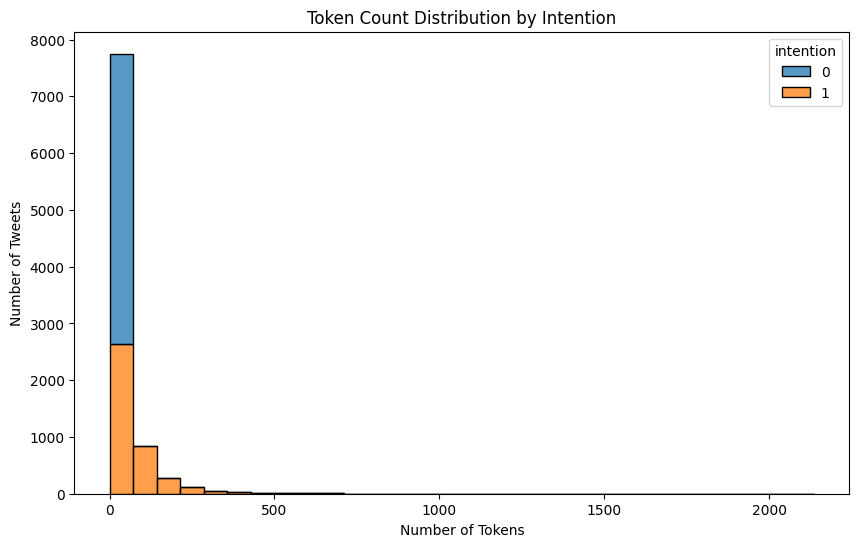

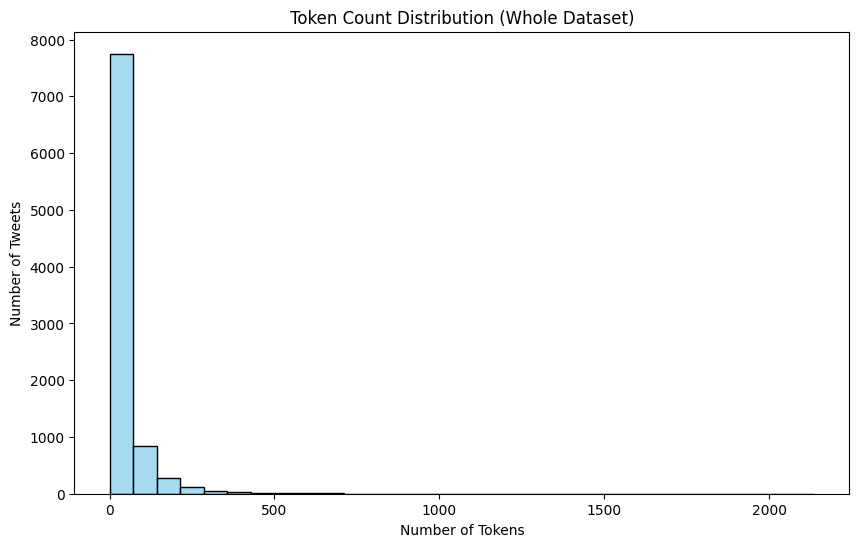

Maximum number of tokens: 2137
Minimum number of tokens: 0
Average number of tokens: 37.28292575940344


In [11]:
dfTemp['num_tokens'] = dfTemp['tweet'].apply(len)

plt.figure(figsize=(10,6))
sns.histplot(data=dfTemp, x='num_tokens', hue='intention', multiple='stack', bins=30)

plt.title('Token Count Distribution by Intention')
plt.xlabel('Number of Tokens')
plt.ylabel('Number of Tweets')
plt.show()

plt.figure(figsize=(10,6))
sns.histplot(dfTemp['num_tokens'], bins=30, color='skyblue')

plt.title('Token Count Distribution (Whole Dataset)')
plt.xlabel('Number of Tokens')
plt.ylabel('Number of Tweets')

plt.show()

print("Maximum number of tokens: "+str(dfTemp['num_tokens'].max()))
print("Minimum number of tokens: "+str(dfTemp['num_tokens'].min()))
print("Average number of tokens: "+str(dfTemp['num_tokens'].mean()))

# Word2Vec - Word Embedding

In [12]:
# print available word2vec models
import gensim.downloader as api
print("\n".join(api.info()['models'].keys()))

fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


In [13]:
W2V_PATH = '/content/drive/My Drive/AI/w2v' # Path to W2V if downloaded
if W2V_PATH is not None and os.path.exists(W2V_PATH):
    print("Loading Word2Vec model...")
    w2v_model = gensim.models.KeyedVectors.load(W2V_PATH, mmap='r')
    print("Word2Vec model is loaded.")
else:
    print("Downloading Word2Vec model...")
    w2v_model = api.load("word2vec-google-news-300")
    print("Word2vec model is downloaded.")
    if W2V_PATH is not None:
      print("\nSaving Word2Vec model...")
      w2v_model.save(W2V_PATH)
      print("Word2Vec model is saved.")

Loading Word2Vec model...
Word2Vec model is loaded.


In [14]:
EMBEDDING_VECTOR_DIM = w2v_model.vector_size

# Dataset

In [15]:
class Twitter(Dataset):
    def __init__(self, dataframe: pd.DataFrame, w2v_model: gensim.models.KeyedVectors, sequence_len: int):
        self.dataframe = dataframe
        self.w2v_model = w2v_model
        self.max_sequence_len = sequence_len
        self.vector_size = w2v_model.vector_size

        self.df_token_col = "tokens"


        self._proc_dataset()

        self.len = len(self.dataframe)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.dataframe.iloc[idx]["vector"], self.dataframe.iloc[idx]["intention"]

    def get_vector_size(self):
        return self.vector_size

    def _proc_dataset(self):
        # Preprocess and return tokens list
        self.dataframe[self.df_token_col] = self.dataframe["tweet"].map(preprocess_data)

        # delete samples with empty tokens
        lwz = len(self.dataframe)
        self.dataframe = self.dataframe[self.dataframe[self.df_token_col].map(len) > 0]
        self.dataframe.reset_index(drop=True, inplace=True)
        print(f"Deleted 0-Len Samples: {lwz - len(self.dataframe)}")

        # Add padding
        self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)

        # Get embedding's vectors
        self.dataframe["vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)

    def _get_word_vectors(self, tokens: list) -> torch.tensor:
      # TODO: Return a 2D tensor for whole list of tokens, using vectors from w2v as explained on the description
      vector = []
      for token in tokens:
        if token in self.w2v_model:
          vector.append(self.w2v_model[token])
        else:
          vector.append([0]*self.vector_size)
      return self._to_tensor(vector)

    def _pad(self, tokens: list):
        # TODO: Add paddings (zero-vectors) into the end of sequence to reach the desired length
        if len(tokens) >= self.max_sequence_len:
            return tokens[:self.max_sequence_len]
        else:
            return tokens + [0] * (self.max_sequence_len - len(tokens))
    def seq_report(self):
        length_all = self.dataframe[self.df_token_col].map(len).tolist()
        max_length = np.max(length_all)
        print(f"Sequence Length Report")
        print(f":::::MAX  LENGTH:::[{max_length:^5}]")
        print(f":::::MIN  LENGTH:::[{np.min(length_all):^5}]")
        print(f":::::MEAN LENGTH:::[{np.mean(length_all):^5}]")

        all_tokens = set()
        for token_set in self.dataframe[self.df_token_col].tolist():
            all_tokens = all_tokens.union(set(token_set))
        unique_tokens_count = len(all_tokens)
        valid_tokens = sum(1 if token in self.w2v_model else 0 for token in all_tokens)
        print("Sequence Tokenization Report")
        print(f":::::All Unique Tokens:::[{unique_tokens_count:^6}")
        print(f":::::All Valid Tokens:::[{valid_tokens:^6}")
        print(f":::::Valid Tokens:::[{round(100*valid_tokens/unique_tokens_count, 2):^5}%]")

    @staticmethod
    def _to_tensor(tokens: list):
        return torch.tensor(tokens, dtype=torch.float32)

# Prepare Data

## Split Data into train-valid

In [16]:
# TODO: Split dataset into train-test split
train_df, valid_df = train_test_split(df, test_size=0.25, random_state=42)

## Create Datasets

In [17]:
# TODO: create twitter dataset
train_dataset = Twitter(
    train_df,w2v_model,SEQUENCE_LEN
)
valid_dataset = Twitter(
    valid_df,w2v_model,SEQUENCE_LEN
)


Deleted 0-Len Samples: 22


/tmp/ipython-input-15-554835015.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)
/tmp/ipython-input-15-554835015.py:76: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  return torch.tensor(tokens, dtype=torch.float32)
/tmp/ipython-input-15-554835015.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

Deleted 0-Len Samples: 9


/tmp/ipython-input-15-554835015.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)
/tmp/ipython-input-15-554835015.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe["vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)


In [18]:
print(f"Train dataset length: {len(train_dataset)}")
print(f"Valid dataset length: {len(valid_dataset)}")

Train dataset length: 6817
Valid dataset length: 2271


# Model and Train

## Utils

In [19]:
@torch.no_grad()
def model_eval(model, loader, loss_function, device: str):
    """Returns test_loss, test_acc"""
    test_loss = 0.0
    test_acc = 0.0

    if device == "auto":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    itr = tqdm(loader, total=len(loader), leave=False)

    for inputs, labels in itr:
        # TODO: move model's inputs to `device`
        inputs = inputs.permute(0, 2, 1)
        inputs = inputs.to(device)
        labels = labels.to(device)
        # TODO: use model's forward pass to generate outputs
        outputs = model(inputs)
        # TODO: calculate model's loss
        # loss =
        loss = loss_function(outputs, labels)
        test_loss += loss.item() * inputs.size(0)  # sum over batch
        # TODO: calculate/update model's accuracy
        preds = outputs.argmax(dim=1)
        correct = (preds == labels).sum().item()
        test_acc += correct

        itr.set_description("(Eval)")
        itr.set_postfix(
            loss=round(loss.item(), 5),
            accuracy=round(test_acc, 5),
        )
    #test_loss /= len(loader.dataset)
    #test_acc /= len(loader.dataset)
    return test_loss, test_acc


In [20]:
def train_model(
        model,
        batch_size,
        loss_function,
        optimizer,
        epochs,
        train_set,
        valid_set,
        device: str,
):

    if device == "auto":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)

    train_losses = []
    train_accs = []

    valid_losses = []
    valid_accs = []

    # TODO: create dataloaders from datasets
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True)

    model.to(device)

    itr = tqdm(train_loader, total=len(train_loader), leave=False)

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        epoch_acc = 0
        for idx, (inputs, labels) in enumerate(itr, start=1):
            # TODO: move model's inputs to `device`
            inputs = inputs.permute(0, 2, 1)
            inputs = inputs.to(device)
            labels = labels.to(device)
            # TODO: use model's forward pass to generate outputs
            outputs = model(inputs)
            # TODO: process model's predictipns and calculate/update accuracy
            preds = outputs.argmax(dim=1)
            correct = (preds == labels).sum().item()
            epoch_acc += correct
            # TODO: calculate model's loss and update epoch's loss
            # loss =
            loss = loss_function(outputs, labels)
            # TODO: 1. clear optimizer's state and zero prev grads,
            # TODO: 2. backward calculated loss
            # TODO: 3. step optimizer
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * inputs.size(0)

            itr.set_description(f"(Training) Epoch [{epoch + 1}/{epochs}]")
            itr.set_postfix(
              loss=round(loss.item(), 5),
              accuracy=round(epoch_acc, 5),
              )

        model.eval()
        valid_loss, valid_acc = model_eval(
            model=model,
            loader=valid_loader,
            loss_function=loss_function,
            device=device
            )

        # TODO: update statistics regaurding model's loss and acc in training or validation phases
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)
    history = {
      "train_loss": train_losses,
      "train_acc": train_accs,

      "valid_loss": valid_losses,
      "valid_acc": valid_accs,
    }
    return history

In [21]:
def trend_plot_helper(pobj):
    plt.figure(figsize=(5*len(pobj), 5))
    for idx, (titler, plots) in enumerate(pobj.items(), start=1):
        plt.subplot(1, len(pobj), idx)
        for label, trend in plots:
            plt.plot(range(1, len(trend)+1), trend, label=label)
        yt, xt = titler.split(' - ')
        plt.xlabel(xt)
        plt.ylabel(yt)
        plt.legend()

In [22]:
@torch.no_grad()
def generate_confusion_matrix(model, dataset, device='auto'):
    if device == 'auto':
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    itr = tqdm(loader, leave=False, desc="Generate data")

    # TODO: code here, you must fill variables below
    # TODO: labels = true labels from the dataset
    # TODO: predicted = labels predicted by the model
    labels = []
    predicted = []

    for inputs, targets in itr:
        inputs = inputs.permute(0, 2, 1)
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)
        preds = outputs.argmax(dim=1)  # Get class with highest score

        labels.extend(targets.cpu().tolist())
        predicted.extend(preds.cpu().tolist())

    cm = metrics.confusion_matrix(
        y_true=labels,
        y_pred=predicted,
    )

    plt.figure(figsize=(10,10))
    sns.heatmap(cm, cmap='Blues', annot=True, cbar=False, fmt=".0f",)
    plt.xlabel('Predicted Label', labelpad=20)
    plt.ylabel('True Label', labelpad=20)
    plt.title('Confusion Matrix', fontsize=30)

    recall = metrics.recall_score(y_true=labels, y_pred=predicted, average='macro')
    f1 = metrics.f1_score(y_true=labels, y_pred=predicted, average='macro')
    precision = metrics.precision_score(y_true=labels, y_pred=predicted, average='macro')
    report = metrics.classification_report(y_true=labels, y_pred=predicted)

    return {'recall': recall, 'f1': f1, 'precision': precision, 'report': report}


## Model's Network

In [41]:
class CNN(nn.Module):
    def __init__(self): # TODO: define your args here
        super(CNN, self).__init__()

        # TODO: define you network's layers here
        self.conv1_k3 = nn.Conv1d(in_channels=300, out_channels=64, kernel_size=3, padding=1)
        self.conv1_k5 = nn.Conv1d(in_channels=300, out_channels=64, kernel_size=5, padding=2)
        self.conv1_k7 = nn.Conv1d(in_channels=300, out_channels=64, kernel_size=7, padding=3)
        self.conv2_k3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv2_k5 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
        self.conv2_k7 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=7, padding=3)
        self.fc1 = nn.Linear(3 * 128, 128)
        self.fc2 = nn.Linear(128, 2)
    def forward(self, x):

        # TODO: implement forward pass here
        x1 = F.relu(self.conv1_k3(x))
        x2 = F.relu(self.conv1_k5(x))
        x3 = F.relu(self.conv1_k7(x))
        y1 = F.relu(self.conv2_k3(x1))
        y2 = F.relu(self.conv2_k5(x2))
        y3 = F.relu(self.conv2_k7(x3))
        y1 = torch.max(y1, dim=2).values
        y2 = torch.max(y2, dim=2).values
        y3 = torch.max(y3, dim=2).values
        y = torch.cat([y1, y2, y3], dim=1)
        y = F.relu(self.fc1(y))
        y = self.fc2(y)
        return y

## Training

In [42]:
# TODO: instantiate your model here
model = CNN()

In [43]:
cnn_model_train_history = train_model( # TODO: train your model
    model,BATCH_SIZE,nn.CrossEntropyLoss(),torch.optim.Adam(model.parameters(), lr=LEARNING_RATE),EPOCHS,train_dataset,valid_dataset,DEVICE
)

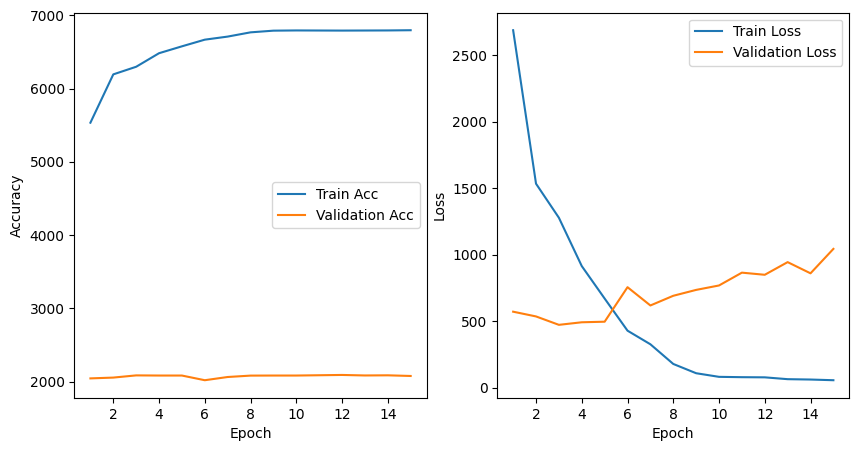

In [44]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", cnn_model_train_history["train_acc"]),
            ("Validation Acc", cnn_model_train_history["valid_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", cnn_model_train_history["train_loss"]),
            ("Validation Loss", cnn_model_train_history["valid_loss"])
        ]
    }
)

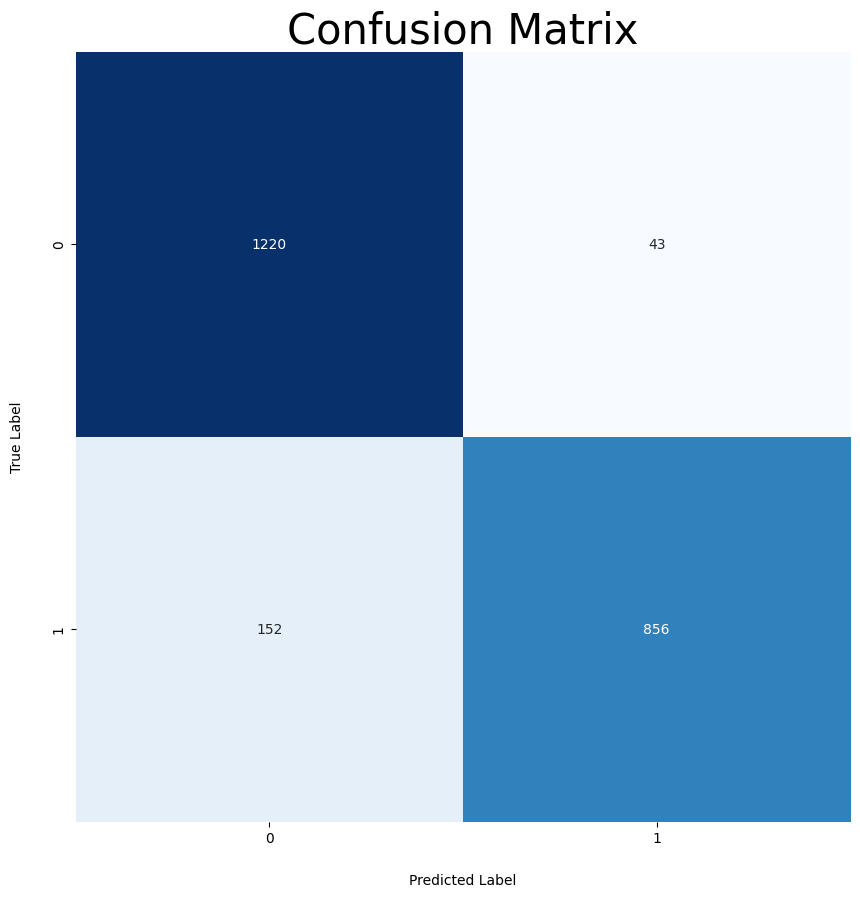

In [45]:
cnn_model_report = generate_confusion_matrix(
    model=model,
    dataset=valid_dataset,
)

In [46]:
print(f"Recall:    {cnn_model_report['recall']:.3f}")
print(f"F1:        {cnn_model_report['f1']:.3f}")
print(f"Precision: {cnn_model_report['precision']:.3f}")
print(cnn_model_report['report'])

Recall:    0.908
F1:        0.912
Precision: 0.921
              precision    recall  f1-score   support

           0       0.89      0.97      0.93      1263
           1       0.95      0.85      0.90      1008

    accuracy                           0.91      2271
   macro avg       0.92      0.91      0.91      2271
weighted avg       0.92      0.91      0.91      2271



# With larger context window


## Config

### Model training config

In [47]:
LEARNING_RATE = 4e-4
WEIGHT_DECAY = 1e-2
BATCH_SIZE = 64
EPOCHS = 15

SEQUENCE_LEN = 196
CNN_FILTERS = 64

## Prepare Data

### Create Datasets

In [48]:
# TODO: create twitter dataset
train_dataset = Twitter(
    train_df,w2v_model,SEQUENCE_LEN
)
valid_dataset = Twitter(
    valid_df,w2v_model,SEQUENCE_LEN
)


Deleted 0-Len Samples: 22


/tmp/ipython-input-15-554835015.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)
/tmp/ipython-input-15-554835015.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe["vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)


Deleted 0-Len Samples: 9


/tmp/ipython-input-15-554835015.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)
/tmp/ipython-input-15-554835015.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe["vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)


In [31]:
print(f"Train dataset length: {len(train_dataset)}")
print(f"Valid dataset length: {len(valid_dataset)}")

Train dataset length: 6817
Valid dataset length: 2271


## Model and Train

### Training

In [33]:
# TODO: instantiate your model here
model = CNN()

In [34]:
cnn_model_train_history = train_model( # TODO: train your model
    model,BATCH_SIZE,nn.CrossEntropyLoss(),torch.optim.Adam(model.parameters(), lr=LEARNING_RATE),EPOCHS,train_dataset,valid_dataset,DEVICE
)

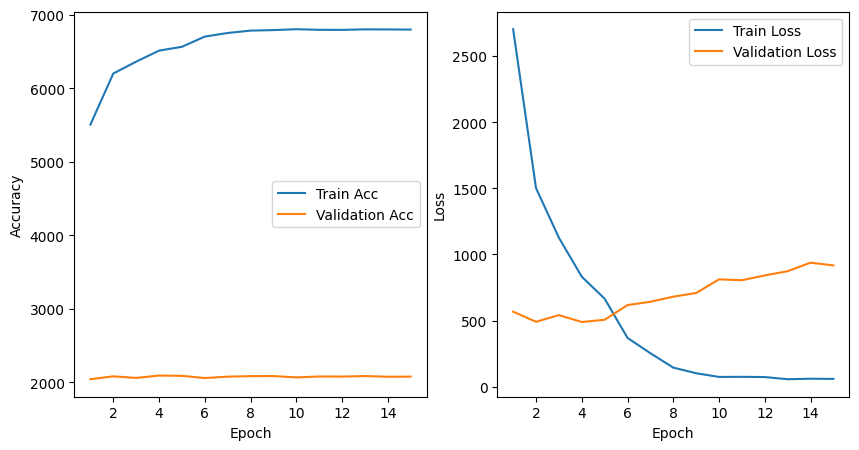

In [35]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", cnn_model_train_history["train_acc"]),
            ("Validation Acc", cnn_model_train_history["valid_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", cnn_model_train_history["train_loss"]),
            ("Validation Loss", cnn_model_train_history["valid_loss"])
        ]
    }
)

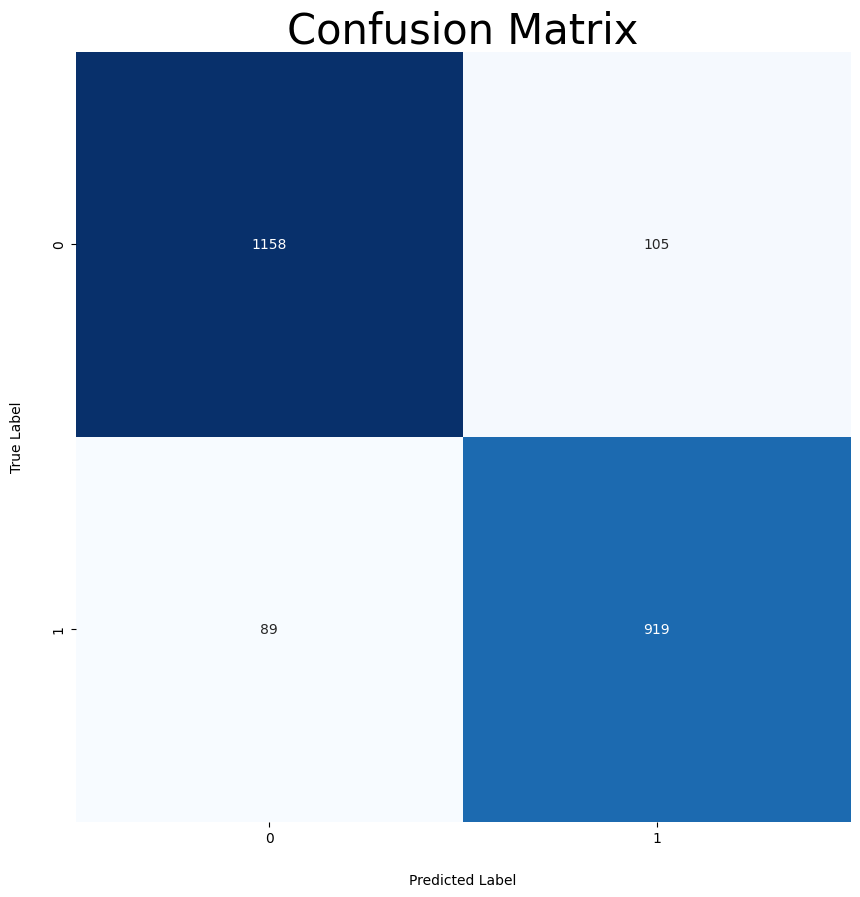

In [37]:
cnn_model_report = generate_confusion_matrix(
    model=model,
    dataset=valid_dataset,
)

In [38]:
print(f"Recall:    {cnn_model_report['recall']:.3f}")
print(f"F1:        {cnn_model_report['f1']:.3f}")
print(f"Precision: {cnn_model_report['precision']:.3f}")
print(cnn_model_report['report'])

Recall:    0.914
F1:        0.914
Precision: 0.913
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      1263
           1       0.90      0.91      0.90      1008

    accuracy                           0.91      2271
   macro avg       0.91      0.91      0.91      2271
weighted avg       0.91      0.91      0.91      2271



# With dropout and batch normalization layers


## Model and Train

### Model's Network

In [55]:
class CNN(nn.Module):
    def __init__(self): # TODO: define your args here
        super(CNN, self).__init__()

        # TODO: define you network's layers here
        self.conv1_k3 = nn.Conv1d(in_channels=300, out_channels=64, kernel_size=3, padding=1)
        self.conv1_k5 = nn.Conv1d(in_channels=300, out_channels=64, kernel_size=5, padding=2)
        self.conv1_k7 = nn.Conv1d(in_channels=300, out_channels=64, kernel_size=7, padding=3)
        self.bn1_k3 = nn.BatchNorm1d(64)
        self.bn1_k5 = nn.BatchNorm1d(64)
        self.bn1_k7 = nn.BatchNorm1d(64)
        self.conv2_k3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv2_k5 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
        self.conv2_k7 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=7, padding=3)
        self.bn2_k3 = nn.BatchNorm1d(128)
        self.bn2_k5 = nn.BatchNorm1d(128)
        self.bn2_k7 = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(3 * 128, 128)
        self.bn_fc1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 2)
    def forward(self, x):

        # TODO: implement forward pass here
        x1 = F.relu(self.bn1_k3(self.conv1_k3(x)))
        x2 = F.relu(self.bn1_k5(self.conv1_k5(x)))
        x3 = F.relu(self.bn1_k7(self.conv1_k7(x)))
        y1 = F.relu(self.bn2_k3(self.conv2_k3(x1)))
        y2 = F.relu(self.bn2_k5(self.conv2_k5(x2)))
        y3 = F.relu(self.bn2_k7(self.conv2_k7(x3)))
        y1 = torch.max(y1, dim=2).values
        y2 = torch.max(y2, dim=2).values
        y3 = torch.max(y3, dim=2).values
        y = torch.cat([y1, y2, y3], dim=1)
        y = self.dropout(F.relu(self.bn_fc1(self.fc1(y))))
        y = self.fc2(y)
        return y

### Training

In [56]:
# TODO: instantiate your model here
model = CNN()

In [57]:
cnn_model_train_history = train_model( # TODO: train your model
    model,BATCH_SIZE,nn.CrossEntropyLoss(),torch.optim.Adam(model.parameters(), lr=LEARNING_RATE),EPOCHS,train_dataset,valid_dataset,DEVICE
)

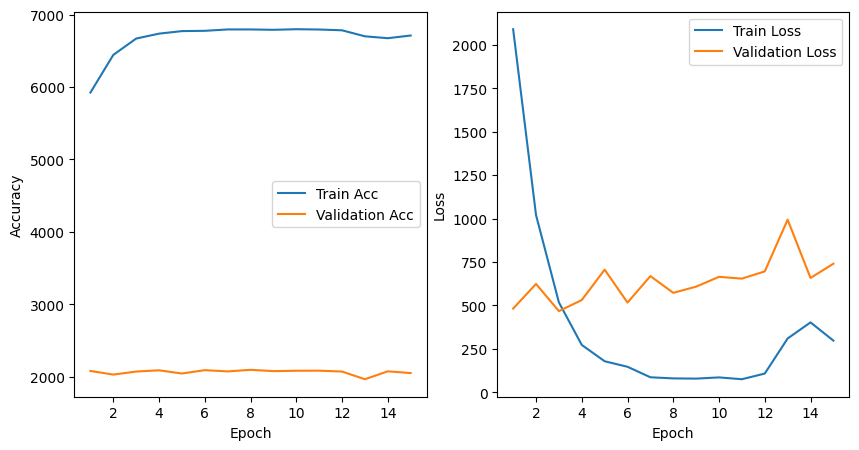

In [58]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", cnn_model_train_history["train_acc"]),
            ("Validation Acc", cnn_model_train_history["valid_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", cnn_model_train_history["train_loss"]),
            ("Validation Loss", cnn_model_train_history["valid_loss"])
        ]
    }
)

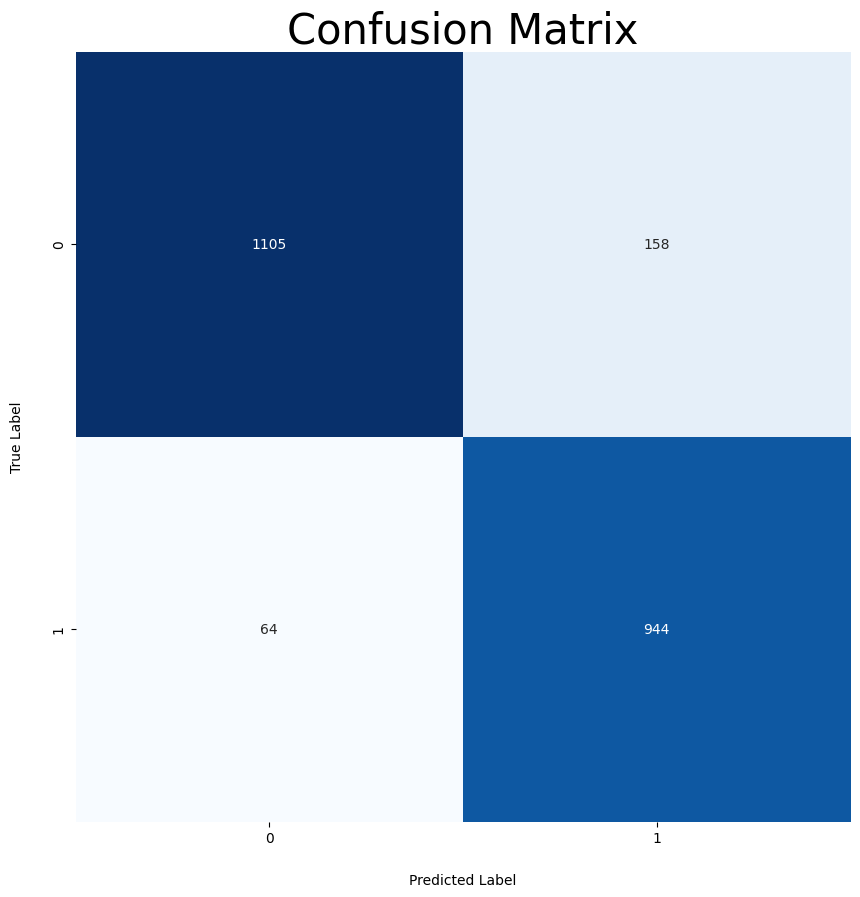

In [59]:
cnn_model_report = generate_confusion_matrix(
    model=model,
    dataset=valid_dataset,
)

In [60]:
print(f"Recall:    {cnn_model_report['recall']:.3f}")
print(f"F1:        {cnn_model_report['f1']:.3f}")
print(f"Precision: {cnn_model_report['precision']:.3f}")
print(cnn_model_report['report'])

Recall:    0.906
F1:        0.902
Precision: 0.901
              precision    recall  f1-score   support

           0       0.95      0.87      0.91      1263
           1       0.86      0.94      0.89      1008

    accuracy                           0.90      2271
   macro avg       0.90      0.91      0.90      2271
weighted avg       0.91      0.90      0.90      2271

